# Review of Google's DMCA requests

Data downloaded on Aug. 3, 2023 from: https://transparencyreport.google.com/copyright/overview?hl=en&copyright_result_owner=&copyright_result_org=&copyright_result_domain=&search_copyright=q:https&lu=search_copyright

In [1]:
import pandas as pd
import requests

In [2]:
!ls

1.Google-DMCA Data.ipynb        backup
2.Lumen data.ipynb              data
3. Cleaning and Filtering.ipynb df_suspicious_2023.csv
4. Clustering.ipynb             source_urls.csv
README.md                       unique_copyrighted.csv
Webshrinker.ipynb               unique_infringing.csv


In [3]:
df = pd.read_csv('data/google-websearch-copyright-removals/requests.csv')
df.shape

(19111391, 12)

In [4]:
df.head()

,Request ID,Date,Lumen URL,Copyright owner ID,Copyright owner name,Reporting organization ID,Reporting organization name,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review,From Abuser
0,1,2012-05-23T21:59:06Z,http://www.chillingeffects.org/notice.cgi?sID=...,22818,BPI (British Recorded Music Industry) Ltd,1847,BPI (British Recorded Music Industry) Ltd,1,0,0,0,False
1,10,2011-12-07T09:22:01Z,http://www.chillingeffects.org/notice.cgi?sID=...,25445,SEOmoz.ir,2951,seomoz.ir,6,0,4,0,False
2,100,2012-04-28T09:11:10Z,http://www.chillingeffects.org/notice.cgi?sID=...,22818,BPI (British Recorded Music Industry) Ltd,1847,BPI (British Recorded Music Industry) Ltd,7,0,0,0,False
3,1000,2012-04-06T20:06:21Z,http://www.chillingeffects.org/notice.cgi?sID=...,33428,"Malibu Media, LLC",6913,"Malibu Media, LLC",1,0,0,0,False
4,10000,2012-02-08T10:12:54Z,http://www.chillingeffects.org/notice.cgi?sID=...,25224,Microsoft Corporation,34,Pulin Thakkar,995,0,2,0,False


In [9]:
len(df)

19111391

# 1. First analysis

A few questions I may want to ask to get started:

* How many requests per year
* How many URLs removed per year

In [10]:
df.dtypes

Request ID                                      int64
Date                                           object
Lumen URL                                      object
Copyright owner ID                              int64
Copyright owner name                           object
Reporting organization ID                       int64
Reporting organization name                    object
URLs removed                                    int64
URLs that were not in Google's search index     int64
URLs for which we took no action                int64
URLs pending review                             int64
From Abuser                                      bool
dtype: object

In [11]:
#Format date as datetime
df['Date'] = pd.to_datetime(df['Date'])

# 1.1. Notices per year

In [12]:
requests_year_df = df.groupby(df.Date.dt.year)['Date'].agg(count = 'count').reset_index()
requests_year_df = requests_year_df.rename(columns = {'Date':'year', 'count':'count_requests'})
requests_year_df


,year,count_requests
0,2011,35489
1,2012,427969
2,2013,479930
3,2014,830892
4,2015,1190423
5,2016,1251759
6,2017,1298762
7,2018,1584766
8,2019,1484747
9,2020,1888346


<Axes: xlabel='year'>

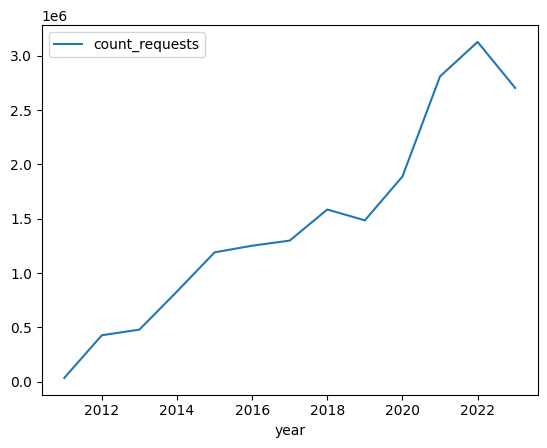

In [13]:
requests_year_df.plot.line('year', 'count_requests')

## 1.2 Successful requests

In [16]:
df['URLs removed'].sum()

4340984252

In [17]:
urls_removed_year = df.groupby(df.Date.dt.year)['URLs removed'].sum().reset_index()
urls_removed_year = urls_removed_year.rename(columns = {'Date':'year', 'URLs removed':'count_removed'})
urls_removed_year

,year,count_removed
0,2011,3197728
1,2012,54319455
2,2013,221927688
3,2014,320914554
4,2015,519878515
5,2016,914685496
6,2017,695140288
7,2018,226560479
8,2019,186433855
9,2020,262796471


<Axes: xlabel='year'>

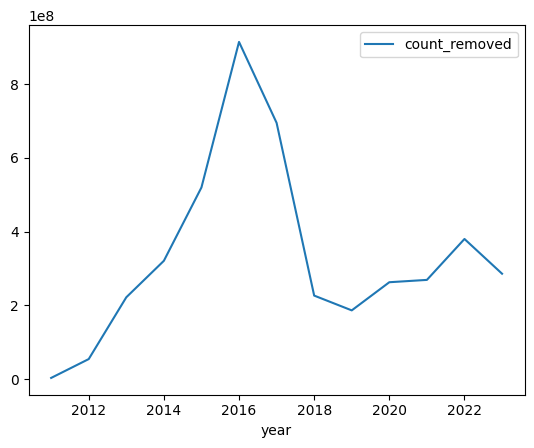

In [18]:
urls_removed_year.plot.line('year', 'count_removed')

Probably we can now merge the two df

In [20]:
df1 = requests_year_df.merge(urls_removed_year)
df1

,year,count_requests,count_removed
0,2011,35489,3197728
1,2012,427969,54319455
2,2013,479930,221927688
3,2014,830892,320914554
4,2015,1190423,519878515
5,2016,1251759,914685496
6,2017,1298762,695140288
7,2018,1584766,226560479
8,2019,1484747,186433855
9,2020,1888346,262796471


Save to .csv for future visualization

In [21]:
df1.to_csv('data/requests_v_removed.csv')

## 2. Looking for the 'suspicious' requests

From all those million requests we want to extract those that are likely to be fraudulent. To do so, we will need to use the Lumen API and get the full details of each requests. However, we need to reduce our dataset first.

### 2.1 Filtering only successful requests
We will only keep notices that resulted in at least one URL removed from Google.

In [22]:
df_removed = df[df['URLs removed'] != 0]
df_removed.head()

,Request ID,Date,Lumen URL,Copyright owner ID,Copyright owner name,Reporting organization ID,Reporting organization name,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review,From Abuser
0,1,2012-05-23 21:59:06+00:00,http://www.chillingeffects.org/notice.cgi?sID=...,22818,BPI (British Recorded Music Industry) Ltd,1847,BPI (British Recorded Music Industry) Ltd,1,0,0,0,False
1,10,2011-12-07 09:22:01+00:00,http://www.chillingeffects.org/notice.cgi?sID=...,25445,SEOmoz.ir,2951,seomoz.ir,6,0,4,0,False
2,100,2012-04-28 09:11:10+00:00,http://www.chillingeffects.org/notice.cgi?sID=...,22818,BPI (British Recorded Music Industry) Ltd,1847,BPI (British Recorded Music Industry) Ltd,7,0,0,0,False
3,1000,2012-04-06 20:06:21+00:00,http://www.chillingeffects.org/notice.cgi?sID=...,33428,"Malibu Media, LLC",6913,"Malibu Media, LLC",1,0,0,0,False
4,10000,2012-02-08 10:12:54+00:00,http://www.chillingeffects.org/notice.cgi?sID=...,25224,Microsoft Corporation,34,Pulin Thakkar,995,0,2,0,False


In [23]:
df_removed.shape

(15415716, 12)

15 million results is still a lot. We will try to do this only for the last year.

### 2.2. Filtering to only have successful requests from 2023

In [24]:
df_removed_2023 = df_removed[df_removed['Date'].dt.year >= 2023]
df_removed_2023.shape

(2066806, 12)

In [25]:
df_removed_2023

,Request ID,Date,Lumen URL,Copyright owner ID,Copyright owner name,Reporting organization ID,Reporting organization name,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review,From Abuser
4609073,14149509,2023-05-08 04:39:56+00:00,https://lumendatabase.org/notices/27384479,402291,"CHANGDU TECHNOLOGY (USA) CO., LTD.",695806,"CHANGDU TECHNOLOGY (USA) CO., LTD.",1,0,1,0,False
5271671,14746021,2023-05-08 04:39:56+00:00,https://lumendatabase.org/notices/28133424,212840,COA,261070,"MWSTORY Co., Ltd.",16,1,1,0,False
5324989,14794029,2023-03-10 12:35:30+00:00,https://lumendatabase.org/notices/28179885,368860,Dillon Roman,227224,Rulta OU,37,5,13,0,False
5447722,14904527,2023-02-06 05:49:19+00:00,https://lumendatabase.org/notices/28329265,327203,Club with contract,715234,YSS Inc.,26,31,127,0,False
5538256,14986047,2023-02-10 02:39:08+00:00,https://lumendatabase.org/notices/28422289,400567,"CHANGDU TECHNOLOGY (USA) CO.,LTD.",717161,"CHANGDU TECHNOLOGY (USA) CO.,LTD.",5,59,4,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10131582,19120847,2023-07-30 03:19:02+00:00,https://lumendatabase.org/notices/35224430,406376,diana killingsworth,360291,DMCA Piracy Prevention Inc,11,0,0,0,False
10131583,19120848,2023-07-30 02:16:37+00:00,https://lumendatabase.org/notices/35223612,484280,darcie dolce,360291,DMCA Piracy Prevention Inc,14,3,0,0,False
10131584,19120849,2023-07-29 12:50:51+00:00,https://lumendatabase.org/notices/35214233,539407,madi ruve,360291,DMCA Piracy Prevention Inc,7,1,0,0,False
10131586,19120850,2023-07-29 18:47:41+00:00,https://lumendatabase.org/notices/35219459,409921,supershycharlotte,227224,Rulta OU,1,0,0,0,False


Two million notices is still too much to ask to the Lumen API. Maybe we can filter out reporting organizations that are recognizible as legit.

### 2.3 Filtering to remove more active (and likely legit) petitioners

In [27]:
reporting_orgs = df_removed_2023['Reporting organization name'].value_counts().reset_index()
reporting_orgs.columns = ['Reporting organization name', 'Count']
reporting_orgs.head(20)


,Reporting organization name,Count
0,Rulta OU,632053
1,DMCA Piracy Prevention Inc,292869
2,ContentScan,179392
3,"CONIST Co., Ltd.",145445
4,Group-IB,99657
5,Redpoints Solutions S.L.,61843
6,comeso GmbH,43296
7,rivendell,43290
8,MG Premium Ltd.,27664
9,Smart Protection S.L.,25674


We know from previous reportings that fraudulent DMCA requests are often made using fake names and fictitious identities, changing them frequently.Because of that, we will remove from our analysis all those organizations that sent more than, let's say, 50 requests.

In [42]:
suspicious_orgs = reporting_orgs[reporting_orgs['Count'] < 51]
suspicious_orgs

,Reporting organization name,Count
548,Hangzhou IX Media,50
549,Unger Academy,50
550,LAW&amp;TRUST,50
551,candes cromwell,50
552,Höcker Rechtsanwälte PartGmbB,49
...,...,...
17933,DiscoDSP LLC,1
17934,Accelerated Aviation Training,1
17935,muabanwin,1
17936,armani hadi,1


Now I want to use my `suspicious_orgs` to filter out my 2023 df and see how many requests I have in total

In [43]:
df_suspicious = df_removed_2023[df_removed_2023['Reporting organization name'].isin(suspicious_orgs['Reporting organization name'])]

df_suspicious

,Request ID,Date,Lumen URL,Copyright owner ID,Copyright owner name,Reporting organization ID,Reporting organization name,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review,From Abuser
5898979,15310807,2023-03-09 04:42:05+00:00,https://lumendatabase.org/notices/28811860,446183,Pdl Backup,734327,Pdl Backup,2,24,27,0,False
6414022,15774446,2023-01-06 17:58:13+00:00,https://lumendatabase.org/notices/29362386,459997,Dmca SL.,749074,Dmca SL.,28,0,0,0,False
6419766,15779616,2023-04-05 13:39:47+00:00,https://lumendatabase.org/notices/29375291,183992,KBS,748554,KBS,1,0,1,0,False
6460930,15816666,2023-01-06 19:35:58+00:00,https://lumendatabase.org/notices/29417753,460947,Rewa Riyasat Private Limited,750041,Rewa Riyasat Private Limited,2,0,0,0,False
6461930,15817566,2023-01-06 19:10:33+00:00,https://lumendatabase.org/notices/29415781,317600,Odins Eye Entertainment Pty Ltd,732563,shoot-down_com,304,0,8,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10131391,19120675,2023-07-30 08:02:25+00:00,https://lumendatabase.org/notices/35225652,502072,Elena Victorovich,781493,Elena Victorovich,1,0,0,0,False
10131408,19120690,2023-07-29 19:31:21+00:00,https://lumendatabase.org/notices/35219610,311026,Vinsela Nazarko,325201,Vinsela Nazarko,74,1,0,2,False
10131421,19120701,2023-07-29 18:17:54+00:00,https://lumendatabase.org/notices/35217729,541591,@briinic,817682,@briinic,10,0,0,0,False
10131553,19120820,2023-07-30 02:41:01+00:00,https://lumendatabase.org/notices/35224211,541647,Tam anh hospital,817792,Tam anh hospital,1,0,0,0,False


Now we have a viable number of requests and we are ready to move to Lumen.